# <font color='orange'>Trabajo práctico N° 3</font>
## <font color='cornflowerblue'>Visión por computadora I</font>
### <font color='violet'>Alumno: Zenklusen, Kevin</font>

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en 
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección

1. El siguiente código permite detectar la ubicación del logo una vez en la imagen. En el caso de múltiples logos, indica la mejor región en la que se encuentra el conjunto.
<br>
Para realizar la detección se se preprocesa las imágenes quitando el ruido y utilizando el algoritmo Canny. Luego se escala y rota levemente el template para buscar los matches.
<br>
Esta función pretende ser un método básico de detección, y la filtración de falsos positivos se realiza mediante score.
<br>
El score se calcula mediante una comparación entre el template consigo mismo. Se consideró utilizar los métodos de búscqueda nomralizados (como TM_CCOEFF_NORM), pero se obtenían peores detecciones.
<br>
Los resultados se muestran en la carpeta output.

In [65]:
import cv2
import numpy as np
import os

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def remove_noise(image):
    denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image

def calculate_self_similarity(template, edge_thresh1, edge_thresh2):
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    gray_template = remove_noise(gray_template)
    edges_template = cv2.Canny(gray_template, edge_thresh1, edge_thresh2)
    result = cv2.matchTemplate(edges_template, edges_template, cv2.TM_CCORR)
    _, max_val, _, _ = cv2.minMaxLoc(result)
    return max_val

def multi_scale_template_matching(image, template, scale_range, angle_range, edge_thresh1, edge_thresh2, n_best_matches=1, self_similarity=None):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    gray_image = remove_noise(gray_image)
    gray_template = remove_noise(gray_template)

    image_height, image_width = gray_image.shape
    template_height, template_width = gray_template.shape
    scale_width = image_width / template_width
    scale_height = image_height / template_height
    scale_factor = min(scale_width, scale_height)
    gray_template = cv2.resize(gray_template, (int(template_width * scale_factor), int(template_height * scale_factor)))

    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    edges_image = cv2.Canny(gray_image, edge_thresh1, edge_thresh2)    

    best_matches = []

    for scale in scale_range:
        resized_template = cv2.resize(gray_template, (int(gray_template.shape[1] * scale), int(gray_template.shape[0] * scale)))

        if resized_template.shape[0] > gray_image.shape[0] or resized_template.shape[1] > gray_image.shape[1]:
            continue
        
        for angle in angle_range:
            rotated_template = rotate_image(resized_template, angle)
            rotated_template = cv2.GaussianBlur(rotated_template, (5, 5), 0)
            edges_template = cv2.Canny(rotated_template, edge_thresh1, edge_thresh2)
            result = cv2.matchTemplate(edges_image, edges_template, cv2.TM_CCOEFF)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            similarity_score = (max_val / self_similarity) * 100

            if len(best_matches) < n_best_matches:
                best_matches.append((max_val, max_loc, scale, angle, rotated_template, similarity_score))
                best_matches.sort(reverse=True, key=lambda x: x[0])
            elif max_val > best_matches[-1][0]:
                best_matches[-1] = (max_val, max_loc, scale, angle, rotated_template, similarity_score)
                best_matches.sort(reverse=True, key=lambda x: x[0])

    if not best_matches:
        print("No se encontraron buenos matches.")
        return []

    return best_matches

# Directorio que contiene las imágenes
image_directory = 'images'
template = cv2.imread('template/pattern.png', cv2.IMREAD_COLOR)
scale_range = np.linspace(0.02, 1, 100)
angle_range = range(-2, 3)  # De -2 a 2 grados
edge_thresh1 = 100
edge_thresh2 = 200
n_best_matches = 1  # Número de mejores matches que queremos graficar
match_score = 5.0 # Umbral de detección

output_directory = os.path.join(image_directory, 'output')
os.makedirs(output_directory, exist_ok=True)

# Calcular la similitud del template consigo mismo
self_similarity = calculate_self_similarity(template, edge_thresh1, edge_thresh2)

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        best_matches = multi_scale_template_matching(image, template, scale_range, angle_range, edge_thresh1, edge_thresh2, n_best_matches, self_similarity)
        
        if best_matches:
            for i, (val, loc, scale, angle, match_template, score) in enumerate(best_matches):
                if score > match_score:
                    top_left = loc
                    template_height, template_width = match_template.shape
                    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
                    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
                    cv2.putText(image, f'Match {i+1}: {score:.2f}%', (top_left[0], top_left[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            output_path = os.path.join(output_directory, 'output_' + filename)
            cv2.imwrite(output_path, image)
            print(f'Output guardado en: {output_path} con los {n_best_matches} mejores matches')
        else:
            print(f'No se encontró un buen match para la imagen: {filename}')


Output guardado en: images\output\output_COCA-COLA-LOGO.jpg con los 1 mejores matches
Output guardado en: images\output\output_coca_logo_1.png con los 1 mejores matches
Output guardado en: images\output\output_coca_logo_2.png con los 1 mejores matches
Output guardado en: images\output\output_coca_multi.png con los 1 mejores matches
Output guardado en: images\output\output_coca_retro_1.png con los 1 mejores matches
Output guardado en: images\output\output_coca_retro_2.png con los 1 mejores matches
Output guardado en: images\output\output_logo_1.png con los 1 mejores matches


In [36]:
import cv2
import numpy as np
import os

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def remove_noise(image):
    denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image

def calculate_self_similarity(template, edge_thresh1, edge_thresh2, method):
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    gray_template = remove_noise(gray_template)
    edges_template = cv2.Canny(gray_template, edge_thresh1, edge_thresh2)
    result = cv2.matchTemplate(edges_template, edges_template, method)
    min_val, max_val, _, _ = cv2.minMaxLoc(result)
    if method == cv2.TM_SQDIFF:
        return min_val
    else:
        return max_val

def multi_scale_template_matching(image, template, scale_range, angle_range, edge_thresh1, edge_thresh2, n_best_matches=1, self_similarity=None, method=cv2.TM_CCOEFF):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    gray_image = remove_noise(gray_image)
    gray_template = remove_noise(gray_template)

    image_height, image_width = gray_image.shape
    template_height, template_width = gray_template.shape
    scale_width = image_width / template_width
    scale_height = image_height / template_height
    scale_factor = min(scale_width, scale_height)
    gray_template = cv2.resize(gray_template, (int(template_width * scale_factor), int(template_height * scale_factor)))

    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    edges_image = cv2.Canny(gray_image, edge_thresh1, edge_thresh2)    

    best_matches = []

    for scale in scale_range:
        resized_template = cv2.resize(gray_template, (int(gray_template.shape[1] * scale), int(gray_template.shape[0] * scale)))

        if resized_template.shape[0] > gray_image.shape[0] or resized_template.shape[1] > gray_image.shape[1]:
            continue
        
        for angle in angle_range:
            rotated_template = rotate_image(resized_template, angle)
            edges_template = cv2.Canny(rotated_template, edge_thresh1, edge_thresh2)
            result = cv2.matchTemplate(edges_image, edges_template, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if method == cv2.TM_SQDIFF:
                similarity_score = (self_similarity / min_val) * 100 if min_val != 0 else 100
                match_val = -min_val
                loc = min_loc
            else:
                similarity_score = (max_val / self_similarity) * 100
                match_val = max_val
                loc = max_loc

            if len(best_matches) < n_best_matches:
                best_matches.append((match_val, loc, scale, angle, rotated_template, similarity_score))
                best_matches.sort(reverse=True, key=lambda x: x[0])
            elif match_val > best_matches[-1][0]:
                best_matches[-1] = (match_val, loc, scale, angle, rotated_template, similarity_score)
                best_matches.sort(reverse=True, key=lambda x: x[0])

    if not best_matches:
        print("No se encontraron buenos matches.")
        return []

    return best_matches

# Directorio que contiene las imágenes
image_directory = 'images'
template = cv2.imread('template/pattern.png', cv2.IMREAD_COLOR)
scale_range = np.linspace(0.05, 1.0, 100)
angle_range = range(-5, 6)  # De -5 a 5 grados
edge_thresh1 = 100
edge_thresh2 = 200
n_best_matches = 5  # Número de mejores matches que queremos graficar

output_directory = os.path.join(image_directory, 'output')
os.makedirs(output_directory, exist_ok=True)

# Métodos de template matching a evaluar
methods = [cv2.TM_CCOEFF, cv2.TM_CCORR, cv2.TM_SQDIFF]

for method in methods:
    method_name = {cv2.TM_CCOEFF: 'TM_CCOEFF', cv2.TM_CCORR: 'TM_CCORR', cv2.TM_SQDIFF: 'TM_SQDIFF'}[method]
    # Calcular la similitud del template consigo mismo
    self_similarity = calculate_self_similarity(template, edge_thresh1, edge_thresh2, method)

    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_directory, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            best_matches = multi_scale_template_matching(image, template, scale_range, angle_range, edge_thresh1, edge_thresh2, n_best_matches, self_similarity, method)
            
            if best_matches:
                for i, (val, loc, scale, angle, match_template, score) in enumerate(best_matches):
                    top_left = loc
                    template_height, template_width = match_template.shape
                    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
                    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
                    cv2.putText(image, f'Match {i+1}: {score:.2f}% ({method_name})', (top_left[0], top_left[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

                output_path = os.path.join(output_directory, f'output_{method_name}_' + filename)
                cv2.imwrite(output_path, image)
                print(f'Output guardado en: {output_path} con los {n_best_matches} mejores matches usando {method_name}')
            else:
                print(f'No se encontró un buen match para la imagen: {filename} usando {method_name}')


Output guardado en: images\output\output_TM_CCOEFF_COCA-COLA-LOGO.jpg con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_coca_logo_1.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_coca_logo_2.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_coca_multi.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_coca_retro_1.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_coca_retro_2.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCOEFF_logo_1.png con los 5 mejores matches usando TM_CCOEFF
Output guardado en: images\output\output_TM_CCORR_COCA-COLA-LOGO.jpg con los 5 mejores matches usando TM_CCORR
Output guardado en: images\output\output_TM_CCORR_coca_logo_1.png con los 5 mejores matches usando TM_CCORR
Output guard

2.

In [47]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Leer la imagen principal y el template
img_rgb = cv.imread('images/coca_multi.png')
assert img_rgb is not None, "El archivo no pudo ser leído, verifica con os.path.exists()"
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "El archivo no pudo ser leído, verifica con os.path.exists()"

# Definir el rango de escalas a probar
scales = np.linspace(0.2, 1.0, 100)

# Inicializar una lista para almacenar los puntos encontrados
all_points = []

def remove_noise(image):
    # Aplicar un filtro bilateral para eliminar el ruido
    denoised_image = cv.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image


template = remove_noise(template)

#img_gray = cv.GaussianBlur(img_gray, (5, 5), 0)
template = cv.GaussianBlur(template, (5, 5), 0)
img_gray = cv.Canny(img_gray, 150, 200)
template = cv.Canny(template, 150, 200)

cv.imshow('Imagen Original vs Nueva', img_gray)
cv.waitKey(0)
cv.destroyAllWindows()

# Iterar sobre las diferentes escalas
for scale in scales:
    # Redimensionar el template según la escala actual
    width = int(template.shape[1] * scale)
    height = int(template.shape[0] * scale)
    resized_template = cv.resize(template, (width, height))
    
    # Realizar la búsqueda del template en la imagen
    res = cv.matchTemplate(img_gray, resized_template, cv.TM_CCORR_NORMED)
    threshold = 0.28
    loc = np.where(res >= threshold)
    
    # Almacenar los puntos encontrados
    for pt in zip(*loc[::-1]):
        all_points.append((pt, (pt[0] + width, pt[1] + height)))

# Dibujar los rectángulos en la imagen original
for pt1, pt2 in all_points:
    cv.rectangle(img_rgb, pt1, pt2, (0, 255, 255), 2)

# Guardar la imagen con los resultados
cv.imwrite('Multi_detect.png', img_rgb)

True

In [54]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt

def remove_noise(image):
    # Aplicar un filtro bilateral para eliminar el ruido
    denoised_image = cv.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image

def process_image(image_path, template):
    img_rgb = cv.imread(image_path)
    assert img_rgb is not None, f"El archivo {image_path} no pudo ser leído, verifica con os.path.exists()"
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

    # Preprocesamiento de la imagen principal
    img_gray = remove_noise(img_gray)    
    #img_gray = cv.GaussianBlur(img_gray, (5, 5), 0)
    
    img_gray = cv.Canny(img_gray, 150, 200)
    
    # Definir el rango de escalas a probar
    scales = np.linspace(0.2, 3.0, 150)
    
    # Inicializar una lista para almacenar los puntos encontrados
    all_points = []
    
    # Obtener las dimensiones de la imagen principal
    img_height, img_width = img_gray.shape
    
    # Iterar sobre las diferentes escalas y rotaciones
    for scale in scales:
        width = int(template.shape[1] * scale)
        height = int(template.shape[0] * scale)
        
        # Validar que el template redimensionado no sea mayor que la imagen
        if width > img_width or height > img_height:
            continue
        
        resized_template = cv.resize(template, (width, height))
        
        for angle in range(-2, 3):
            rotated_template = rotate_image(resized_template, angle)
            
            # Validar que el template rotado no sea mayor que la imagen
            if rotated_template.shape[1] > img_width or rotated_template.shape[0] > img_height:
                continue
            
            # Realizar la búsqueda del template en la imagen
            res = cv.matchTemplate(img_gray, rotated_template, cv.TM_CCORR_NORMED)
            threshold = 0.28
            loc = np.where(res >= threshold)
            
            # Almacenar los puntos encontrados
            for pt in zip(*loc[::-1]):
                all_points.append((pt, (pt[0] + rotated_template.shape[1], pt[1] + rotated_template.shape[0])))
    
    # Dibujar los rectángulos en la imagen original
    for pt1, pt2 in all_points:
        cv.rectangle(img_rgb, pt1, pt2, (0, 255, 255), 2)
    
    # Guardar la imagen con los resultados
    output_path = os.path.join('results', os.path.basename(image_path))
    os.makedirs('results', exist_ok=True)
    cv.imwrite(output_path, img_rgb)
    print(f'Resultados guardados en: {output_path}')

def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, matrix, (image.shape[1], image.shape[0]), flags=cv.INTER_LINEAR)
    return rotated

# Leer el template y aplicar preprocesamiento
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "El archivo template/pattern.png no pudo ser leído, verifica con os.path.exists()"
template = remove_noise(template)
template = cv.GaussianBlur(template, (5, 5), 0)
template = cv.Canny(template, 150, 200)

# Procesar todas las imágenes en la carpeta 'images'
image_folder = 'images'
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(image_folder, filename)
        process_image(image_path, template)


Resultados guardados en: results\COCA-COLA-LOGO.jpg
Resultados guardados en: results\coca_logo_1.png
Resultados guardados en: results\coca_logo_2.png
Resultados guardados en: results\coca_multi.png
Resultados guardados en: results\coca_retro_1.png
Resultados guardados en: results\coca_retro_2.png
Resultados guardados en: results\logo_1.png


In [22]:
import cv2 as cv
import numpy as np

# Leer la imagen principal y el template
img_rgb = cv.imread('images/coca_multi.png')
assert img_rgb is not None, "El archivo no pudo ser leído, verifica con os.path.exists()"
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "El archivo no pudo ser leído, verifica con os.path.exists()"

# Parámetros para la pirámide
max_levels = 5  # Número de niveles de la pirámide
threshold = 0.5  # Umbral para la coincidencia de templates

# Inicializar lista para almacenar puntos encontrados
all_points = []

# Crear una copia de la imagen original para las anotaciones
img_result = img_rgb.copy()

# Iterar sobre los niveles de la pirámide
for level in range(max_levels):
    # Calcular la escala actual
    scale = 1 / (2 ** level)
    
    # Redimensionar el template según la escala actual
    width = int(template.shape[1] * scale)
    height = int(template.shape[0] * scale)
    if width < 1 or height < 1:
        break
    resized_template = cv.resize(template, (width, height))
    
    # Realizar la búsqueda del template en la imagen
    res = cv.matchTemplate(img_gray, resized_template, cv.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)
    
    # Ajustar los puntos encontrados a la escala original
    for pt in zip(*loc[::-1]):
        w, h = resized_template.shape[::-1]
        all_points.append((pt, (pt[0] + w, pt[1] + h)))

# Dibujar los rectángulos en la imagen original
for pt1, pt2 in all_points:
    cv.rectangle(img_result, pt1, pt2, (255, 0, 255), 2)

# Guardar la imagen con los resultados
cv.imwrite('res.png', img_result)


True

3. Un posible problema para el algoritmo White-Patch se presenta cuando hay píxeles del mismo color que el valor de referencia (En nuestro caso 255), ya que en la fórmula tendremos (R;G;B) = (R*valor_ref/R_max;G*valor_ref/G_max;B*valor_ref/B_max) = (R*1;G*1;B*1).
En este caso no se verá ninguna modificación en la imagen.
Esto se comprobó agregando un círculo blanco a la imagen wp_red.png (ahora wp_red_white_circle.png).

In [21]:
import cv2

# Cargamos la imagen
imagen_original = cv2.imread('white_patch/wp_red_white_circle.png')

# Aplicamos La función
imagen_filtrada = white_patch(imagen_original)

# Concatenar horizontalmente las dos imágenes
imagen_concatenada = np.hstack((imagen_original, imagen_filtrada))

# Mostrar ambas imágenes
cv2.imshow('Imagen Original vs Nueva', imagen_concatenada)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Parte 2

1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas. 
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. 
Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, 
¿considera que puede ser de utilidad tomar como ‘features’ a los histogramas?
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los 
elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes 
separadas.


1. 

In [12]:
import cv2

# Cargamos las imágenes
img1 = cv2.imread('img1_tp.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('img2_tp.png', cv2.IMREAD_GRAYSCALE)

cv2.imshow('Imagen 1', img1)
cv2.imshow('Imagen 2', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

2. 

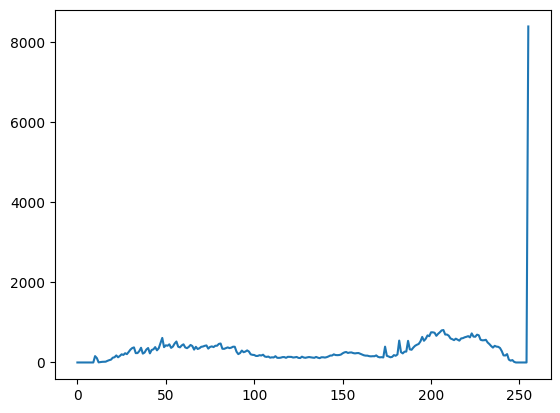

In [17]:
# Graficamos el histograma de la primera imagen
import numpy as np
import matplotlib.pyplot as plt


# Dadas las características de las imágenes, el número de bins utilizado será 256, 
# ya que permite representar el valor de todos los píxeles de 8 bits en escala de grises.
hist1, bins1 = np.histogram(img1, 256, [0, 256])
plt.plot(hist1)

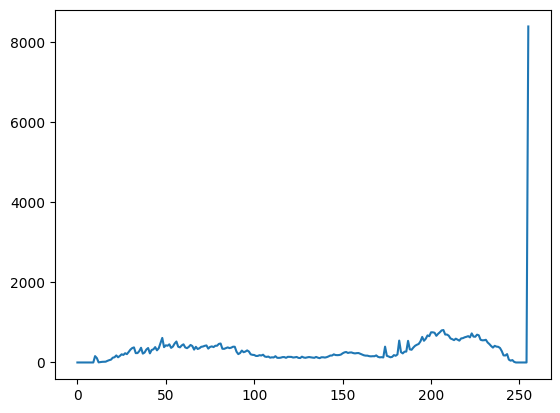

In [14]:
# Graficamos el histograma de la segunda imagen
hist2, bins2 = np.histogram(img2, 256, [0, 256])
plt.plot(hist2)

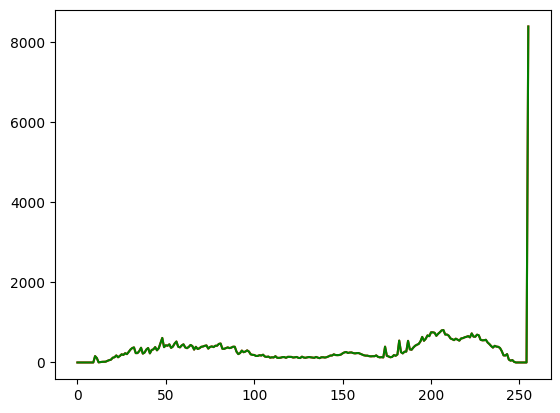

In [15]:
# Graficamos ambos histograma en el mismo gráfico
plt.plot(hist1, color='r', label='Imagen 1')
plt.plot(hist2, color='g', label='Imagen 2')
plt.show()

Observamos que ambos histogramas son iguales. Esto se debe a que la distribución de grises de las imágenes es la misma pero los píxeles están ubicados en distintas posiciones, lo que genera imágenes totalemente distintas pese a tener las mismas tonalidades.
Podemos concluir a partir de esto, que el histograma es un mal descriptor de imágenes que será poco práctico para entrenar un clasificador de imágenes.

3. 

In [166]:
%matplotlib tkagg

import cv2
import matplotlib.pyplot as plt

# Cargamos la imagen color
img_color = cv2.imread('segmentacion.png')
# La convertimos a HSV
img_HSV = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)

# Msotramos la imagen
plt.figure(1)
plt.imshow(img_HSV)
plt.show()

# Graficamos los perfiles de intensidad de cada canal para la primera fila
plt.figure(2)
idx_col = 1
perfil_color = img_HSV[:, idx_col]
plt.plot(perfil_color[:,0], color='r',label='H')
plt.plot(perfil_color[:,1], color='g',label='S')
plt.plot(perfil_color[:,2], color='b',label='V')
plt.xlabel('Fila')
plt.ylabel('Intensidad')
plt.title('Perfil sobre la columna {}'.format(idx_col))
plt.grid()
plt.xlim(0,480)
plt.ylim(0,255)
plt.legend()
plt.show()

# Graficamos los perfiles de intensidad de cada canal para la última fila
plt.figure(3)
idx_col = img_HSV.shape[1]-1
perfil_color = img_HSV[:, idx_col]
plt.plot(perfil_color[:,0], color='r',label='H')
plt.plot(perfil_color[:,1], color='g',label='S')
plt.plot(perfil_color[:,2], color='b',label='V')
plt.xlabel('Fila')
plt.ylabel('Intensidad')
plt.title('Perfil sobre la columna {}'.format(idx_col))
plt.grid()
plt.xlim(0,480)
plt.ylim(0,255)
plt.legend()
plt.show()

In [167]:
# Cortamos una porción de la imagen para poder obtener los valores de HSV correspondientes a la misma.
# En este caso, el cielo.
img_muestra_hsv = img_HSV[0:260,:,:]
plt.imshow(img_muestra_hsv)
plt.show()

# Calculamos un modelo estadístico sencillo para caracterizar el color
color_mean = cv2.mean(img_muestra_hsv)
    
print(color_mean)

(102.84641213980143, 186.88522883202842, 216.90963354588746, 0.0)


In [168]:
# Para los siguientes valores, se utilizaron los calculados como refierencia,
# pero se utilizaron los obtenidos en base a los histogramas
color_l = (99,25,155)
color_u = (110,255,255)

mask = cv2.inRange(img_HSV, color_l,  color_u)
img_segmentada = cv2.bitwise_and(img_color, img_color, mask=mask)
img_segmentada_rgb = cv2.cvtColor(img_segmentada, cv2.COLOR_BGR2RGB)

plt.figure(4)
plt.imshow(img_segmentada_rgb)
plt.show()

In [169]:
# Restamos la imagen segmentada de la imagen original para quitar el cielo
img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_sin_cielo = img_color_rgb - img_segmentada_rgb

plt.imshow(img_sin_cielo)
plt.show()

In [170]:
# Procedemos a sacar las piedras
img_muestra_zona_piedras = img_color_rgb[540:img_color_rgb.shape[0]-1,:,:]
plt.figure(1)
plt.imshow(img_muestra_zona_piedras)
plt.show()
plt.figure(2)
img_muestra_hsv_2 = img_HSV[540:img_color_rgb.shape[0]-1,:,:]
plt.imshow(img_muestra_hsv_2)
plt.show()

# Graficamos los perfiles de intensidad de cada canal para la primera fila
plt.figure(3)
idx_col = 1
perfil_color = img_muestra_hsv_2[:, idx_col]
plt.plot(perfil_color[:,0], color='r',label='H')
plt.plot(perfil_color[:,1], color='g',label='S')
plt.plot(perfil_color[:,2], color='b',label='V')
plt.xlabel('Fila')
plt.ylabel('Intensidad')
plt.title('Perfil sobre la columna {}'.format(idx_col))
plt.grid()
plt.xlim(0,480)
plt.ylim(0,255)
plt.legend()
plt.show()

# Graficamos los perfiles de intensidad de cada canal para la última fila
plt.figure(4)
idx_col = img_HSV.shape[1]-1
perfil_color = img_muestra_hsv_2[:, idx_col]
plt.plot(perfil_color[:,0], color='r',label='H')
plt.plot(perfil_color[:,1], color='g',label='S')
plt.plot(perfil_color[:,2], color='b',label='V')
plt.xlabel('Fila')
plt.ylabel('Intensidad')
plt.title('Perfil sobre la columna {}'.format(idx_col))
plt.grid()
plt.xlim(0,480)
plt.ylim(0,255)
plt.legend()
plt.show()

In [172]:
# Aquí se utilizaron valores en base a los histogramas
color_l = (0,0,0)
color_u = (25,255,255)

mask_2 = cv2.inRange(img_HSV, color_l,  color_u)
img_segmentada_2 = cv2.bitwise_and(img_color, img_color, mask=mask_2)
img_segmentada_rgb_2 = cv2.cvtColor(img_segmentada_2, cv2.COLOR_BGR2RGB)

plt.figure(4)
plt.imshow(img_segmentada_rgb_2)
plt.show()

In [173]:
# Restamos la imagen segmentada de la imagen original para quitar el cielo
img_sin_cielo_y_sin_piedras = img_sin_cielo - img_segmentada_rgb_2

plt.imshow(img_sin_cielo_y_sin_piedras)
plt.show()